In [18]:
import pandas as pd
import numpy as np

In [19]:
df = pd.read_csv("PlayerStatistics.csv")
df.head()

C:\Users\Zero\AppData\Local\Temp\ipykernel_14988\1188862187.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("PlayerStatistics.csv")


,firstName,lastName,personId,gameId,gameDateTimeEst,playerteamCity,playerteamName,opponentteamCity,opponentteamName,gameType,...,threePointersPercentage,freeThrowsAttempted,freeThrowsMade,freeThrowsPercentage,reboundsDefensive,reboundsOffensive,reboundsTotal,foulsPersonal,turnovers,plusMinusPoints
0,Buddy,Hield,1627741,22500323,2025-12-02 18:00:00,Golden State,Warriors,Oklahoma City,Thunder,NaN,...,0.222,3.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,-12.0
1,Gary,Payton II,1627780,22500323,2025-12-02 18:00:00,Golden State,Warriors,Oklahoma City,Thunder,NaN,...,1.000,1.0,1.0,1.0,4.0,1.0,5.0,2.0,3.0,-9.0
2,Shai,Gilgeous-Alexander,1628983,22500323,2025-12-02 18:00:00,Oklahoma City,Thunder,Golden State,Warriors,NaN,...,0.833,10.0,7.0,0.7,3.0,0.0,3.0,2.0,0.0,10.0
3,Kenrich,Williams,1629026,22500323,2025-12-02 18:00:00,Oklahoma City,Thunder,Golden State,Warriors,NaN,...,0.500,0.0,0.0,0.0,2.0,0.0,2.0,1.0,1.0,-9.0
4,Isaiah,Joe,1630198,22500323,2025-12-02 18:00:00,Oklahoma City,Thunder,Golden State,Warriors,NaN,...,0.750,0.0,0.0,0.0,3.0,0.0,3.0,3.0,2.0,4.0


In [20]:
df['gameDateTimeEst'] = pd.to_datetime(df['gameDateTimeEst'], utc=True, errors="coerce")
df = df[df['gameDateTimeEst'].dt.year >= 2016].copy()

In [21]:
team_cols = [
    'points', 'assists', 'reboundsTotal', 'steals', 'blocks', 
    'turnovers', 'fieldGoalsMade', 'fieldGoalsAttempted', 
    'threePointersMade', 'threePointersAttempted', 'freeThrowsMade', 'freeThrowsAttempted'
]

team_df = df.groupby(['gameId', 'playerteamName', 'gameDateTimeEst', 'opponentteamName'])[team_cols].sum().reset_index()

team_df['win'] = df.groupby(['gameId', 'playerteamName'])['win'].max().reset_index()['win']

team_df['team_efficiency'] = (
    team_df['points'] + team_df['reboundsTotal'] + team_df['assists'] + 
    team_df['steals'] + team_df['blocks'] - team_df['turnovers'] - 
    (team_df['fieldGoalsAttempted'] - team_df['fieldGoalsMade']) - 
    (team_df['freeThrowsAttempted'] - team_df['freeThrowsMade'])
)

team_df = team_df.sort_values(['playerteamName', 'gameDateTimeEst'])

In [22]:
rolling_features = ['points', 'assists', 'reboundsTotal', 'team_efficiency', 'win']
window_size = 10

for col in rolling_features:
    team_df[f'roll_{col}_10'] = team_df.groupby('playerteamName')[col].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean().shift(1)
    )

opp_stats = team_df[['gameId', 'playerteamName'] + [f'roll_{c}_10' for c in rolling_features]].copy()
opp_stats = opp_stats.rename(columns={'playerteamName': 'opponentteamName'})
opp_stats.columns = ['gameId', 'opponentteamName'] + [f'opp_roll_{c}_10' for c in rolling_features]

In [23]:
final_df = pd.merge(team_df, opp_stats, on=['gameId', 'opponentteamName'], how='left')

final_df = final_df.dropna()

cols_to_drop = [
    'points', 'assists', 'reboundsTotal', 'steals', 'blocks', 'turnovers',
    'fieldGoalsMade', 'fieldGoalsAttempted', 'threePointersMade', 
    'threePointersAttempted', 'freeThrowsMade', 'freeThrowsAttempted', 
    'team_efficiency'
]
final_df = final_df.drop(columns=cols_to_drop)

In [24]:
final_df.to_csv("team_rolling_stats.csv", index=False)
final_df.head()

,gameId,playerteamName,gameDateTimeEst,opponentteamName,win,roll_points_10,roll_assists_10,roll_reboundsTotal_10,roll_team_efficiency_10,roll_win_10,opp_roll_points_10,opp_roll_assists_10,opp_roll_reboundsTotal_10,opp_roll_team_efficiency_10,opp_roll_win_10
2,21500512,76ers,2016-01-04 19:00:00+00:00,Timberwolves,1,91.500000,25.500000,41.50,100.000000,0.000000,85.000000,19.000000,47.000000,92.000000,0.000000
3,21500536,76ers,2016-01-07 19:00:00+00:00,Hawks,0,97.333333,27.333333,40.00,112.666667,0.333333,99.000000,24.000000,36.500000,102.500000,0.000000
4,21500554,76ers,2016-01-09 19:30:00+00:00,Raptors,0,97.500000,25.750000,40.75,108.500000,0.250000,101.000000,18.600000,42.600000,115.000000,0.600000
5,21500559,76ers,2016-01-10 18:00:00+00:00,Cavaliers,0,97.000000,25.800000,39.60,108.400000,0.200000,118.000000,22.000000,45.000000,139.250000,1.000000
6,21500587,76ers,2016-01-14 19:00:00+00:00,Bulls,0,95.000000,25.166667,41.00,106.500000,0.166667,106.714286,22.285714,48.857143,125.571429,0.571429


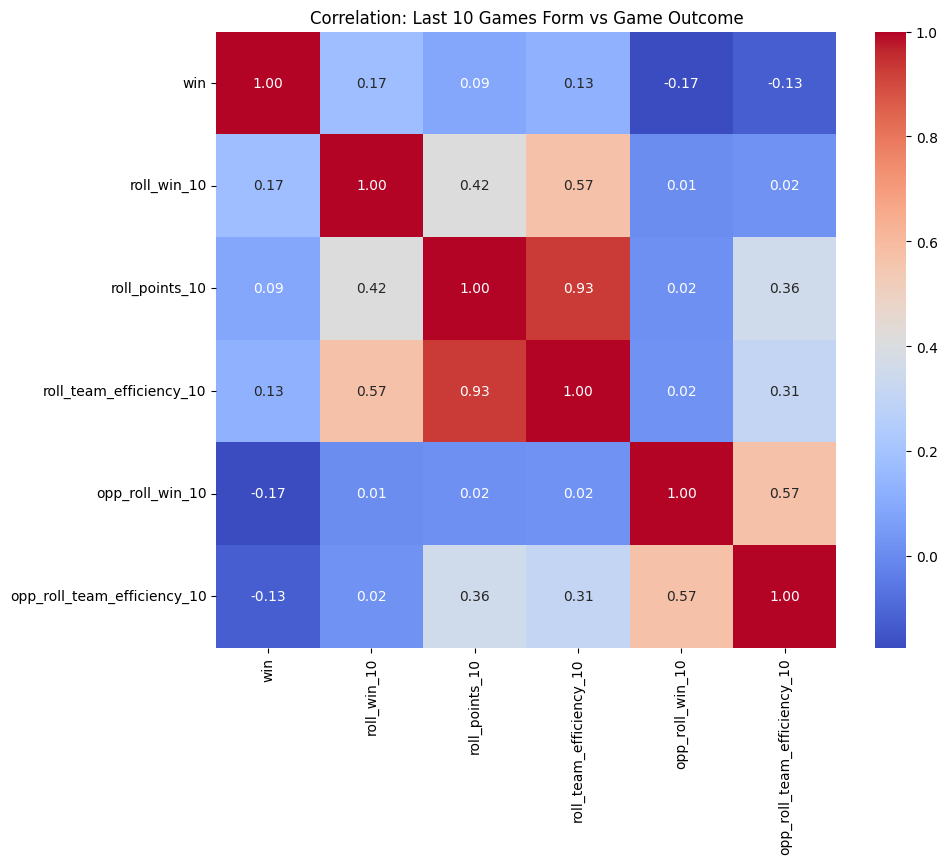

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_cols = ['win', 'roll_win_10', 'roll_points_10', 'roll_team_efficiency_10', 
             'opp_roll_win_10', 'opp_roll_team_efficiency_10']

plt.figure(figsize=(10, 8))
sns.heatmap(final_df[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Last 10 Games Form vs Game Outcome")
plt.show()